# TAP_verify_DP0.1-forced_photometry

<br>Owner: **Douglas Tucker** ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker))
<br>Updated for DC2 by:   Douglas Tucker  following in part work for DESC by Yao-Yuan Mao (@yymao) and Johann Cohen-Tanugi (@johannct)
<br>Last Verified to Run: **2021-08-23**
<br>Verified Stack Release: **w_2021_25**

### Objectives

This notebook is meant to run tests of the basic content of DP0.1 TAPserver `force_photometry` table in the `dp01_dc2_catalogs` schema on the IDF.

### Logistics

This notebook is intended to be runnable on `data.lsst.cloud` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


In [1]:
# https://jira.lsstcorp.org/browse/PREOPS-473
# 
# create a separate notebook "for general consumption" (with more notes).
# More important now than comparing against parquet files.
# "Here's a description of what the DB looks like. -- a good product to hand off."
# Maybe do some of this within the SQL query:  can SQL test for NaN's?"
# Point towards the data, not so much the DB mechanics.
# Cols:  max, min, 1%, 99%
# qserv has a data return limit of 5GB; so beware!

### Set Up

In [2]:
# Import general python packages
import numpy as np
import pandas as pd
import os
import time
from datetime import datetime
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [5]:
# Import the Rubin TAP service utilities
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query, get_catalog

# Get an instance of the TAP service
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


### User Input

In [6]:
# Which table are we interested in for this notebook?
schema_name = 'dp01_dc2_catalogs'
table_name = 'forced_photometry'
table_full_name = """%s.%s""" % (schema_name, table_name)

# Output directory and output file basename info
outputDir = '/home/douglasleetucker/WORK'
baseName = 'TAP_verify_DP01'

# Debug option for quick results for testing purposes:
#    True:  only runs over a few tracts of data
#    False:  runs over all tracts available
debug = True

# Do query step (e.g., if this very long step hasn't already been run before)?
do_query_step = True

# Do analysis step (e.g., if this long step hasn't already been run before?)
do_analysis_step = False

# Do plotting step (e.g., if this step hasn't already been run before?)
do_plotting_step = False

# Do final cleanup?
do_final_cleanup = False

# Level of output to screen (0, 1, 2, ...)
verbose = 2

### Useful Modules

In [7]:
# # # # # # # # # # # # # # # # # # # #
# Plotting module...                  #
# # # # # # # # # # # # # # # # # # # #

def makeTractSanityPlots(df, column_name, table_full_name, outputFileName, nbins=50):

    # 
    # Define binning parameters for the different plots
    # 

    # values
    alist = []
    alist.extend(list(df[df['column']==column_name]['1%'].values))
    alist.extend(list(df[df['column']==column_name]['50%'].values))
    alist.extend(list(df[df['column']==column_name]['99%'].values))
    val_range = max(alist) - min(alist)
    val_min = min(alist) - 0.10*val_range
    val_max = max(alist) + 0.10*val_range
    val_nbins = nbins
    delta_val = (val_max - val_min)/val_nbins
    val_bins = np.arange(val_min, val_max, delta_val)
    if verbose> 2:  print(val_bins)

    # numbers
    alist = []
    alist.extend(list(df[df['column']==column_name]['n_nan'].values))
    alist.extend(list(df[df['column']==column_name]['n_tot'].values))
    num_range = max(alist) - min(alist)
    num_min = 0
    num_max = max(alist) + 0.10*val_range
    num_nbins = nbins
    delta_num = (num_max - num_min)/num_nbins
    num_bins = np.arange(num_min, num_max, delta_num)
    if verbose> 2:  print(num_bins)

    # fractions
    frac_min = 0.00
    frac_max = 1.00
    frac_nbins = nbins
    delta_frac = (frac_max - frac_min)/frac_nbins
    frac_bins = np.arange(frac_min, frac_max, delta_frac)
    if verbose> 2:  print(frac_bins)
        
    #
    # Plot plots...
    #

    fig = plt.figure(figsize=(20,10))

    fig.subplots_adjust(hspace=0.5)
    supTitle = """Tract-Level Diagnostics\nTable:  %s\nColumn:  %s""" % (table_full_name, column_name) 
    fig.suptitle(supTitle)
    plt.rcParams.update({'font.size': 14})

    plt.subplot(322)
    values = (df[df['column']==column_name]['1%']).values
    ax = plt.hist(values, bins=val_bins)
    plt.title("quantile: 1%", x=0.50, y =0.80)
    plt.xlabel(column_name)
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(324)
    values = (df[df['column']==column_name]['50%']).values
    ax = plt.hist(values, bins=val_bins)
    plt.title("quantile: 50%", x=0.50, y =0.80)
    plt.xlabel(column_name)
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(326) 
    values = (df[df['column']==column_name]['99%']).values
    ax = plt.hist(values, bins=val_bins)
    plt.title("quantile: 99%", x=0.50, y =0.80)
    plt.xlabel(column_name)
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(321) 
    values = (df[df['column']==column_name]['n_nan']).values
    ax = plt.hist(values, bins=num_bins)
    plt.title("N_nan", x=0.50, y =0.80)
    plt.xlabel('n_nan')
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(323) 
    values = (df[df['column']==column_name]['n_tot']).values
    ax = plt.hist(values, bins=num_bins)
    plt.title("N_tot", x=0.50, y =0.80)
    plt.xlabel('n_tot')
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(325) 
    values = (df[df['column']==column_name]['f_nan']).values
    ax = plt.hist(values, bins=frac_bins)
    plt.title("Frac_nan", x=0.50, y =0.80)
    plt.xlabel('Fraction of NaNs')
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')
    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)


    return 0

### Basic Tests

Since some of the following queries take time, let's measure how long it takes to complete each query cell.  We will use `%%time` to estimate processor and wall clock time, and `datetime.now()` to estimate the total time to send the query and download its results.

In [8]:
%%time
now0=datetime.now()
    
query = """SELECT COUNT(*) FROM %s""" % (table_full_name)
results = service.search(query)
df = results.to_table().to_pandas()
ntot = df['COUNT'].loc[0]
outputLine = """%40s:  %d""" % (table_full_name, ntot)
print(outputLine)

now1=datetime.now()
print("Total time:", now1-now0)

     dp01_dc2_catalogs.forced_photometry:  147088445
Total time: 0:02:31.328297
CPU times: user 16.2 ms, sys: 730 µs, total: 17 ms
Wall time: 2min 31s


Let's see what `tracts` are available in the `dp01_dc2_catalogs.truth_match` table.

In [9]:
#%%time
#now0=datetime.now()
#
## `tract` is not a column in forced_photometry;
##   so we nee to be a little tricky...
#query = """SELECT DISTINCT obj.tract 
#           FROM %s.object as obj
#           JOIN %s as x
#           ON obj.objectId = x.objectId  
#           ORDER BY obj.tract""" % \
#        (schema_name, table_full_name)
#
#print(query)
#
#results = service.search(query)
#
#df = results.to_table().to_pandas()
#tract_list = df['tract'].tolist()
#
#now1=datetime.now()
#print("Total time:", now1-now0)
#
#print(tract_list)

In [10]:
%%time
now0=datetime.now()

# `tract` is not a column in forced_photometry;
#   so we need to be a little tricky...
query = """SELECT DISTINCT obj.tract, obj.patch 
           FROM %s.object as obj
           JOIN %s as x
           ON obj.objectId = x.objectId  
           ORDER BY obj.tract, obj.patch""" % \
        (schema_name, table_full_name)

print(query)

results = service.search(query)

df_tracts_patches = results.to_table().to_pandas()
tract_list = df_tracts_patches['tract'].unique().tolist()
tract_list.sort()

now1=datetime.now()
print("Total time:", now1-now0)

print(tract_list)

SELECT DISTINCT obj.tract, obj.patch 
           FROM dp01_dc2_catalogs.object as obj
           JOIN dp01_dc2_catalogs.forced_photometry as x
           ON obj.objectId = x.objectId  
           ORDER BY obj.tract, obj.patch
Total time: 0:03:19.990227
[2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4429, 4430, 4431, 4432, 4433, 44

In [11]:
df_tracts_patches.head(10)

,tract,patch
0,2723,"0,6"
1,2723,"1,6"
2,2723,"2,6"
3,2723,"3,6"
4,2723,"4,6"
5,2724,"0,6"
6,2724,"1,6"
7,2724,"2,6"
8,2724,"3,6"
9,2724,"4,6"


### Detailed Tests

In [12]:
%%time

schema_name = 'dp01_dc2_catalogs'
table_name = 'forced_photometry'
table_full_name = """%s.%s""" % (schema_name, table_name)
column = 'i_base_SdssShape_xy'
tract = 2723

# From Gaia webpage:
#SELECT ROUND(SQRT(pmra*pmra + pmdec*pmdec), 0) AS muTot, COUNT(*)
#FROM gaiadr1.tgas_source
#GROUP BY muTot
#ORDER BY muTot DESC

#query = """
#        SELECT ROUND(fp.i_base_SdssShape_xy, 0) as bin, COUNT(*)  
#        FROM dp01_dc2_catalogs.forced_photometry as fp  
#        JOIN dp01_dc2_catalogs.object as obj  
#        ON fp.objectId = obj.objectId  
#        WHERE obj.tract=2723  
#        GROUP BY bin
#        ORDER BY bin ASC
#        """


#query = """
#        SELECT MIN(fp.i_base_SdssShape_xy), MAX(fp.i_base_SdssShape_xy) 
#        FROM dp01_dc2_catalogs.forced_photometry as fp  
#        """
min=-9.939587e+07  
max=1.476328e+07


query = """
        SELECT obj.tract, ROUND(fp.i_base_SdssShape_xy, 1) as bin_value, COUNT(*)  
        FROM dp01_dc2_catalogs.forced_photometry as fp  
        JOIN dp01_dc2_catalogs.object as obj  
        ON fp.objectId = obj.objectId  
        GROUP BY tract, bin_value
        ORDER BY tract, bin_value ASC
        """


#with total as (select count(*) as cnt from employee_salary)
#select bucket, sum(cnt) over (order by bucket) / total.cnt from (
#    select width_bucket(salary, 70000, 140000, 20) as bucket, 
#           count(*) as cnt
#    from employee_salary
#    group by bucket 
#    order by bucket) x;


#query = """
#        SELECT x.* 
#        FROM %s as x  
#        JOIN %s.object as obj  
#        ON x.objectId = obj.objectId  
#        WHERE obj.tract=%d 
#        """ % (table_full_name, schema_name, tract)

print(query)

 # First, submit the job.  This creates it but doesn't run the query yet.
job = service.submit_job(query)

# Here's the URL representing your query.  This is what you need to retrieve
# the data again.
print('Job URL is', job.url)

# Now run the query.
job.run()

# Here, you can tell python to wait for the job to finish if you don't want to
# run anything else while you are waiting.  Then we print out the final state.
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)


    


        SELECT obj.tract, ROUND(fp.i_base_SdssShape_xy, 1) as bin_value, COUNT(*)  
        FROM dp01_dc2_catalogs.forced_photometry as fp  
        JOIN dp01_dc2_catalogs.object as obj  
        ON fp.objectId = obj.objectId  
        GROUP BY tract, bin_value
        ORDER BY tract, bin_value ASC
        
Job URL is https://data.lsst.cloud/api/tap/async/m0erkir5ge7wtj22
Job phase is COMPLETED
CPU times: user 73.6 ms, sys: 2.74 ms, total: 76.3 ms
Wall time: 3min 55s


In [13]:
results = job.fetch_result()
df = results.to_table().to_pandas()
print(df)

         tract  bin_value  COUNT
0         2723        NaN      2
1         2723     -295.5      1
2         2723     -176.5      1
3         2723      -34.1      1
4         2723      -28.0      1
...        ...        ...    ...
3930093   5074   161580.8      1
3930094   5074   166285.4      1
3930095   5074   180611.8      1
3930096   5074   225044.9      1
3930097   5074   233338.8      1

[3930098 rows x 3 columns]


In [14]:
df[df.tract==5074]

Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,tract,bin_value,COUNT
3909266,5074,NaN,22896
3909267,5074,-175549.3,1
3909268,5074,-165010.5,1
3909269,5074,-155464.1,1
3909270,5074,-145472.1,1
...,...,...,...
3930093,5074,161580.8,1
3930094,5074,166285.4,1
3930095,5074,180611.8,1
3930096,5074,225044.9,1


(-20.0, 20.0)

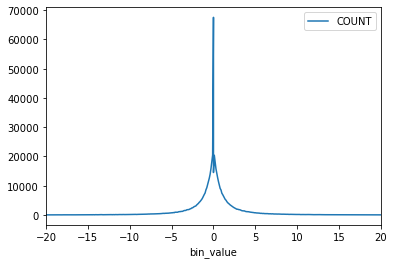

In [15]:
df[df.tract==5074].plot('bin_value', 'COUNT')
plt.xlim(-20, 20)

[2.093000e+02 5.412500e+03 5.596150e+05 6.314685e+05 6.366677e+05]
20831 [  209  5208 10415 15623 20622]
20831 [-2.69005e+04 -1.06080e+03  2.90000e+00  1.09260e+03  2.83277e+04]
67564 10385 0.0
[1 1 1 ... 1 1 1]
[-175549.3 -165010.5 -155464.1 ...  180611.8  225044.9  233338.8]
97.1059142623976


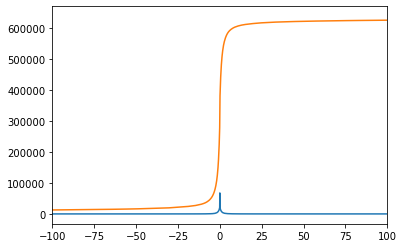

In [16]:
a = np.delete(df[df.tract==5074].COUNT.values,0)
b = np.delete(df[df.tract==5074].bin_value.values,0)

cs = np.cumsum(a)
bin_idx = np.searchsorted(cs, np.percentile(cs, [1,25,50,75,99]))
print(np.percentile(cs, [1,25,50,75,99]))
print(len(cs), bin_idx)

print(len(b), b[bin_idx])

plt.plot(b,a)
plt.xlim(b[bin_idx[1]], b[bin_idx[3]])
plt.plot(b,cs)
#plt.xlim(b[bin_idx[1]], b[bin_idx[3]])
plt.xlim(-100,100)

mode_bin_idx = np.where(a==a.max())[0][0]
print(a.max(), mode_bin_idx, b[mode_bin_idx])  # should use bin midpoints

print(a)
print(b)
print(np.sum(a*b)/len(a)) # should use bin midpoints

# See also https://www.statology.org/histogram-mean-median/
# See also https://stackoverflow.com/questions/22638557/using-numpy-percentile-on-binned-data

In [17]:
%%time

schema_name = 'dp01_dc2_catalogs'
table_name = 'forced_photometry'
table_full_name = """%s.%s""" % (schema_name, table_name)
tract = 5074

query = """SELECT TOP 10000 x.* 
           FROM %s as x  
           JOIN %s.object as obj  
           ON x.objectId = obj.objectId  
                   WHERE obj.tract=%d""" % \
                (table_full_name, schema_name, tract)
print(query)

# First, submit the job.  This creates it but doesn't run the query yet.
job = service.submit_job(query)

# Here's the URL representing your query.  This is what you need to retrieve
# the data again.
print('Job URL is', job.url)

# Now run the query.
job.run()

# Here, you can tell python to wait for the job to finish if you don't want to
# run anything else while you are waiting.  Then we print out the final state.
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)


SELECT TOP 10000 x.* 
           FROM dp01_dc2_catalogs.forced_photometry as x  
           JOIN dp01_dc2_catalogs.object as obj  
           ON x.objectId = obj.objectId  
                   WHERE obj.tract=5074
Job URL is https://data.lsst.cloud/api/tap/async/z2xrn5lpu6csseh6
Job phase is COMPLETED
CPU times: user 57.5 ms, sys: 5.92 ms, total: 63.4 ms
Wall time: 2min 5s


In [18]:
results1 = job.fetch_result()
df1 = results1.to_table().to_pandas()
print(df1)


      coord_dec   coord_ra  g_base_ClassificationExtendedness_flag  \
0    -28.264173  71.812754                                   False   
1    -28.264303  71.834121                                   False   
2    -28.186785  71.767350                                   False   
3    -28.186008  71.768788                                   False   
4    -28.186948  71.805285                                   False   
...         ...        ...                                     ...   
9995 -28.102518  70.730147                                   False   
9996 -28.103190  70.729316                                   False   
9997 -28.099241  70.764468                                   False   
9998 -28.090014  70.803675                                   False   
9999 -28.098852  70.757428                                   False   

      g_base_ClassificationExtendedness_value  g_base_InputCount_flag  \
0                                         1.0                   False   
1            

In [19]:
df1.i_base_SdssShape_xy

0       -0.444569
1        0.648975
2        0.574756
3        0.049095
4       -1.521310
          ...    
9995     0.156035
9996    -0.027013
9997    -6.438901
9998    43.703978
9999     0.004183
Name: i_base_SdssShape_xy, Length: 10000, dtype: float64

In [20]:
import math
print(df1.i_base_SdssShape_xy.std())
print(0.001*df1.i_base_SdssShape_xy.std())
print(math.log10(0.001*df1.i_base_SdssShape_xy.std()))
print(math.floor(math.log10(0.001*df1.i_base_SdssShape_xy.std())))
math.floor(math.log10(0.001*df1.i_base_SdssShape_xy.std()))

1581.3912174407158
1.5813912174407159
0.1990393225305194
0


0

In [21]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [22]:
xxx1 = remove_outlier_IQR(df1.i_base_SdssShape_xy)
print(df1.i_base_SdssShape_xy.min(), df1.i_base_SdssShape_xy.max())
print(xxx1.min(), xxx1.max())
print(xxx1.std())
print(0.01*xxx1.std())
print(math.log10(0.01*xxx1.std()))
print(math.floor(math.log10(0.01*xxx1.std())))
math.floor(math.log10(0.01*xxx1.std()))
ndigits = -1*math.floor(math.log10(0.01*xxx1.std()))

-69849.50309991227 55351.39584040755
-3.7949075208704084 3.8150367001615404
1.3277576185873574
0.013277576185873574
-1.8768811979480218
-2


In [23]:
%%time

schema_name = 'dp01_dc2_catalogs'
table_name = 'forced_photometry'
table_full_name = """%s.%s""" % (schema_name, table_name)
column = 'i_base_SdssShape_xy'
tract = 2723

# From Gaia webpage:
#SELECT ROUND(SQRT(pmra*pmra + pmdec*pmdec), 0) AS muTot, COUNT(*)
#FROM gaiadr1.tgas_source
#GROUP BY muTot
#ORDER BY muTot DESC

#query = """
#        SELECT ROUND(fp.i_base_SdssShape_xy, 0) as bin, COUNT(*)  
#        FROM dp01_dc2_catalogs.forced_photometry as fp  
#        JOIN dp01_dc2_catalogs.object as obj  
#        ON fp.objectId = obj.objectId  
#        WHERE obj.tract=2723  
#        GROUP BY bin
#        ORDER BY bin ASC
#        """


#query = """
#        SELECT MIN(fp.i_base_SdssShape_xy), MAX(fp.i_base_SdssShape_xy) 
#        FROM dp01_dc2_catalogs.forced_photometry as fp  
#        """
#min=-9.939587e+07  
#max=1.476328e+07


query = """
        SELECT obj.tract, ROUND(fp.i_base_SdssShape_xy, %s) as bin_value, COUNT(*)  
        FROM dp01_dc2_catalogs.forced_photometry as fp  
        JOIN dp01_dc2_catalogs.object as obj  
        ON fp.objectId = obj.objectId  
        GROUP BY tract, bin_value
        ORDER BY tract, bin_value ASC
        """ % (ndigits)


#with total as (select count(*) as cnt from employee_salary)
#select bucket, sum(cnt) over (order by bucket) / total.cnt from (
#    select width_bucket(salary, 70000, 140000, 20) as bucket, 
#           count(*) as cnt
#    from employee_salary
#    group by bucket 
#    order by bucket) x;


#query = """
#        SELECT x.* 
#        FROM %s as x  
#        JOIN %s.object as obj  
#        ON x.objectId = obj.objectId  
#        WHERE obj.tract=%d 
#        """ % (table_full_name, schema_name, tract)

print(query)

 # First, submit the job.  This creates it but doesn't run the query yet.
job = service.submit_job(query)

# Here's the URL representing your query.  This is what you need to retrieve
# the data again.
print('Job URL is', job.url)

# Now run the query.
job.run()

# Here, you can tell python to wait for the job to finish if you don't want to
# run anything else while you are waiting.  Then we print out the final state.
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)


    


        SELECT obj.tract, ROUND(fp.i_base_SdssShape_xy, 2) as bin_value, COUNT(*)  
        FROM dp01_dc2_catalogs.forced_photometry as fp  
        JOIN dp01_dc2_catalogs.object as obj  
        ON fp.objectId = obj.objectId  
        GROUP BY tract, bin_value
        ORDER BY tract, bin_value ASC
        
Job URL is https://data.lsst.cloud/api/tap/async/w87o3hwu15su8chy
Job phase is COMPLETED
CPU times: user 85 ms, sys: 3.1 ms, total: 88.1 ms
Wall time: 4min 28s


In [24]:
results = job.fetch_result()
df = results.to_table().to_pandas()
print(df)

         tract  bin_value  COUNT
0         2723        NaN      2
1         2723    -295.47      1
2         2723    -176.48      1
3         2723     -34.12      1
4         2723     -28.00      1
...        ...        ...    ...
7321980   5074  161580.77      1
7321981   5074  166285.44      1
7321982   5074  180611.83      1
7321983   5074  225044.94      1
7321984   5074  233338.85      1

[7321985 rows x 3 columns]


array([[<AxesSubplot:title={'center':'i_base_SdssShape_xy'}>]],
      dtype=object)

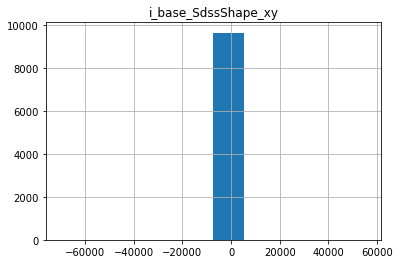

In [25]:
df1.hist('i_base_SdssShape_xy')

In [26]:
raise StopExecution

In [ ]:
# And delete the query once it is done...
job.delete()

These tests take a long time (c. 16 hours).  First perform asynchronous queries on for each of the tracts save the URLs containing the results in a CSV file (in case the job fails; so no need to start completely from scratch.)

In [ ]:
%%time

# The job urls are saved in a file...  just in case...
urls_file_name = """%s.%s.urls.csv""" % (baseName, table_name)
urls_file_name = os.path.join(outputDir,urls_file_name)
print(urls_file_name)

n_tracts = len(tract_list)


# If you have already run this step and haven't run the clean-up step, 
#  you probably want to skip this step ...
if do_query_step==True:

    fout = open(urls_file_name, 'w')
    outputLine = 'tract,patch,url\n'
    fout.write(outputLine)
    fout.close()

    print("""The list of job URLs is being saved in %s, just in case the notebook crashes""" % urls_file_name)

    for tract in tract_list:

        # restart:
        #if tract < 2897: continue

        job = {}

        i_tract = tract_list.index(tract) + 1
        print("""Tract %d  (%d/%d) """ % (tract, i_tract, n_tracts))
        
        df_patches = df_tracts_patches[(df_tracts_patches['tract'] == tract)]
        patch_list = df_patches['patch'].unique().tolist()
        patch_list.sort()
        n_patches = len(patch_list)
        
        for patch in patch_list:
            
            now0=datetime.now()

            i_patch = patch_list.index(patch) + 1
            print("""    patch %s  (%d/%d) """ % (patch, i_patch, n_patches))

        
            now0=datetime.now()
            query = """
                    SELECT x.* 
                    FROM %s as x  
                    JOIN %s.object as obj  
                    ON x.objectId = obj.objectId  
                    WHERE obj.tract=%d and obj.patch='%s'
                    """ % (table_full_name, schema_name, tract, patch)
            print(query)

            # First, submit the job.  This creates it but doesn't run the query yet.
            job[patch] = service.submit_job(query)

            # Here's the URL representing your query.  This is what you need to retrieve
            # the data again.
            print('Job URL is', job[patch].url)
    
            # Save the tract and URL to urls_file_name...
            fout = open(urls_file_name, 'a')
            tmp_patch = patch.replace(',','_')
            outputLine = """%d,'%s',%s\n""" % (tract, tmp_patch, str(job[patch].url))
            fout.write(outputLine)
            fout.close()

            # Here you can see the job's phase, which is PENDING.
            print('Job phase is', job[patch].phase)

            # Now, run the query.
            job[patch].run()

            # Here, you can tell python to wait for the job to finish if you don't want to
            # run anything else while you are waiting.  Then we print out the final state.
            #job[patch].wait(phases=['COMPLETED', 'ERROR'])
            #print('Job phase is', job[patch].phase)

            # Here's a helpful function that will raise an exception if
            # your query had an unfortunate incident.
            #job[patch].raise_if_error()
            #if job[patch].phase == 'ERROR':
            #    print('ERROR!:  QUERY FAILED!')

            now1=datetime.now()
            print("Current time:", now1)
            print("Total time:", now1-now0)
            print("")


        print(datetime.now())
        someExecuting = 9999
        while (someExecuting > 0):
            someExecuting = 0
            for patch in patch_list:
                print(patch, job[patch].phase)
                if job[patch].phase == 'EXECUTING':
                    someExecuting = someExecuting+1
            print(someExecuting)
            time.sleep(60.)
            print(datetime.now())
            
            
        # If we are debugging, let's exit this loop after doing 3 tracts...
        if debug == True:
            if i_tract == 3: break
            #if i_tract == 1: break

In [ ]:
# Reset pandas display.max_colwidth to large number; otherwise URL name is truncated...
pd.set_option("display.max_colwidth", 10000)
#df_urls = pd.read_csv(urls_file_name, index_col='tract', )
df_urls = pd.read_csv(urls_file_name)

if verbose > 1:
    print(df_urls.head(5))
    print(".\n.\n.")
    print(df_urls.tail(5))
df_urls

In [ ]:

print(datetime.now())
while True:
    someExecuting = 0
    for patch in patch_list:
        print(patch, job[patch].phase)
        if job[patch].phase == 'EXECUTING':
            someExecuting = someExecuting+1
    print(someExecuting)
    time.sleep(60.)
    print(datetime.now())
    if someExecuting == 0:
        break

In [ ]:
#raise StopExecution

### Run analysis on returned results for each tract.  Save results in output file...

In [ ]:
%%time

# Create a CSV file to output results from all the tracts...
metaOutputFile = """%s.%s.csv""" % (baseName, table_name)
metaOutputFile = os.path.join(outputDir, metaOutputFile)

if do_analysis_step==True:

    # Write out header line to the metaOutputFile...
    fmout = open(metaOutputFile, 'w')
    metaOutputLine = """tract,column,1%,50%,99%,n_nan,n_tot\n"""
    fmout.write(metaOutputLine)
    fmout.close()

    # Loop over tracts in tract_list...
    for tract in tract_list:
    
        i_tract = tract_list.index(tract) + 1
        print("""Tract %d  (%d/%d) """ % (tract, i_tract, n_tracts))
        
        #if tract < 4644:
        #    continue

        outputFile = """%s.%s.%d.txt""" % (baseName, table_name, tract)
        outputFile = os.path.join(outputDir, outputFile)
    
        try:
            # Grab results...
            job_url = df_urls.loc[tract, 'url']
            print(job_url)
            retrieved_job = retrieve_query(job_url)
            results = retrieved_job.fetch_result()
    
            # Convert the results a Pandas DataFrame...
            df = results.to_table().to_pandas()

            # Output column titles...
            outputLine = '                   column\t        1%         50%         99%       n(Nan)        ntot\n'
            outputLine = outputLine + \
                         '                   ------\t        --         ---         ---       ------        ----\n'
            fout = open(outputFile, 'w')
            fout.write(outputLine)
            fout.close()
    
            # Loop over each column, calculating and outputting the stats...
            for colname in df.columns:
                outputLine1 = "%25s:\t" % (colname)
                metaOutputLine1 = "%d,%s," % (tract, colname)
                try:
                    x = df[colname].quantile([0.01, 0.50, 0.99])
                    outputLine2 = "%10.4g  %10.4g  %10.4g" % (x[0.01], x[0.50], x[0.99])
                    metaOutputLine2 = "%.4g,%.4g,%.4g," % (x[0.01], x[0.50], x[0.99])
                except:
                    outputLine2 = "       ...         ...         ..."
                    metaOutputLine2 = ",,,"
                ntot = len(df.index)
                ntot_nan = df[colname].isna().sum()
                outputLine3 = "          %d          %d" % (ntot_nan, ntot)
                metaOutputLine3 = "%d,%d" % (ntot_nan, ntot)
                outputLine = outputLine1+outputLine2+outputLine3+'\n'
                metaOutputLine = metaOutputLine1+metaOutputLine2+metaOutputLine3+'\n'
                fout = open(outputFile, 'a')
                fout.write(outputLine)
                fout.close()
                fmout = open(metaOutputFile, 'a')
                fmout.write(metaOutputLine)
                fmout.close()

            # Clear memory, make space
            del df, results; gc.collect()   

        except:
        
            print("FAILED")
            outputLine = "FAILED\n"
            fout = open(outputFile, 'w')
            fout.write(outputLine)
            fout.close()
            
        #break


In [ ]:
meta_df = pd.read_csv(metaOutputFile)
meta_df['f_nan'] = meta_df['n_nan']/meta_df['n_tot']
meta_df

In [ ]:
#colname = 'blendedness'
#status = makeTractSanityPlots(meta_df, colname, table_full_name, nbins=50)

In [ ]:
#meta_df[meta_df['column']=="blendedness"].hist(['99%'])

In [ ]:
colnames_set = set(meta_df.column)
colnames_list = (list(colnames_set))
colnames_list.sort()

for colname in colnames_list:
    print(colname+':  ', end = '')
    try:
        outputFileName = """%s.%s.%s.png""" % (baseName, table_full_name, colname)
        print(outputFileName, end = '')
        outputFileName = os.path.join(outputDir, outputFileName)
        status = makeTractSanityPlots(meta_df, colname, table_full_name, outputFileName, nbins=50)
    except:
        print("   FAILED", end = '')
    print('')

In [ ]:
#del meta_df

### Final Cleanup 

Let's delete all the leftover asynchronous job results.

In [ ]:
# Cleanup for object results...

if do_final_cleanup == True:

    for tract in tract_list:

        i_tract = tract_list.index(tract) + 1
        
        try:
            job_url = df_urls.loc[tract, 'url']
            retrieved_job = retrieve_query(job_url)
            retrieved_job.delete()
            print("""Tract %d  (%d/%d):  JOB DELETED (%s)""" % (tract, i_tract, n_tracts, job_url))
        
        except:
            try:
                print("""Tract %d  (%d/%d):  JOB NOT FOUND (%s)""" % (tract, i_tract, n_tracts, job_url))
            except:
                print("""Tract %d  (%d/%d):  JOB NOT FOUND""" % (tract, i_tract, n_tracts))